# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
dir_root = '/nrs/ahrens/jing/giving_up/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'
dask_tmp = '/opt/data/weiz/dask-worker-space'
memory_limit = 0 # unlimited

nsplit = (16, 32)

0


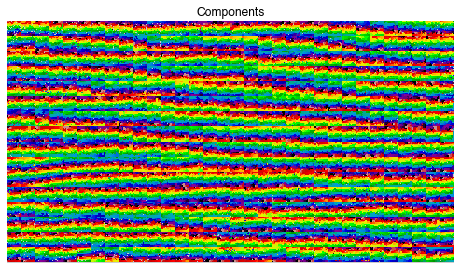

1


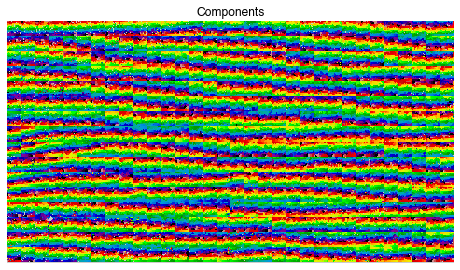

2


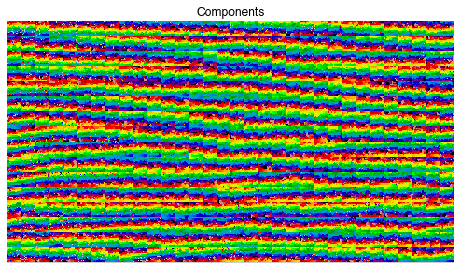

3


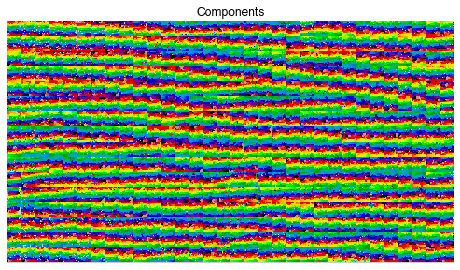

4


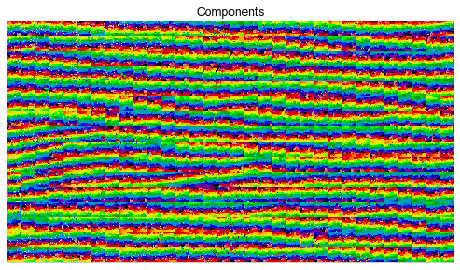

5


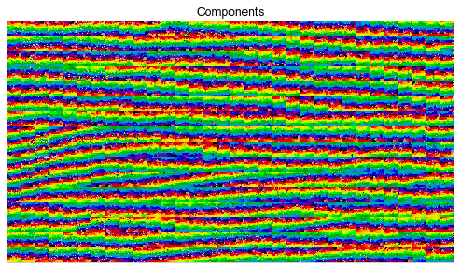

6


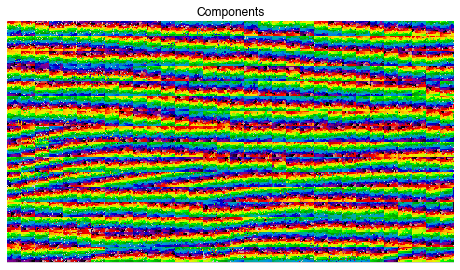

7


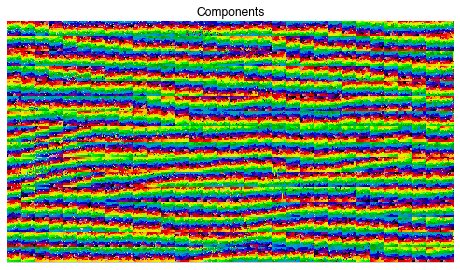

8


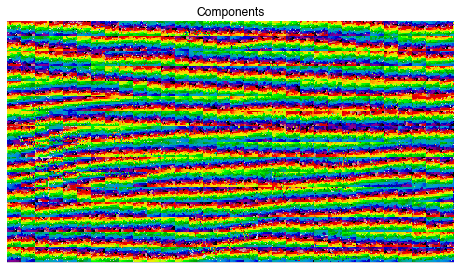

9


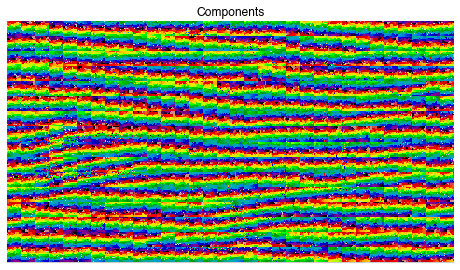

10


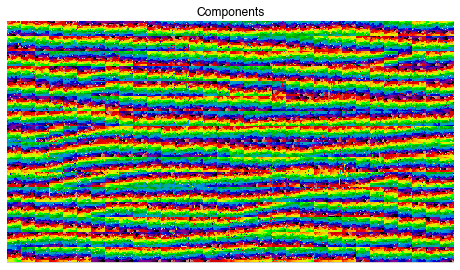

11


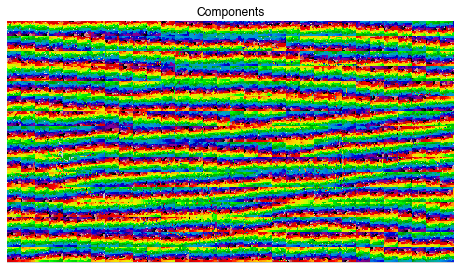

12


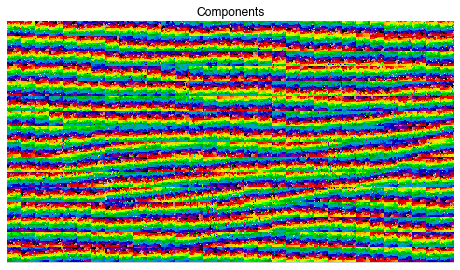

13


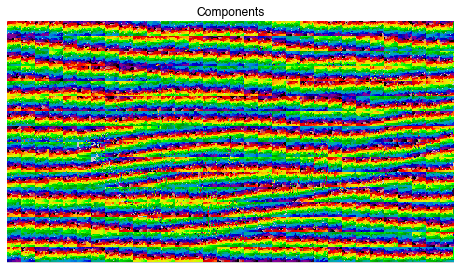

14


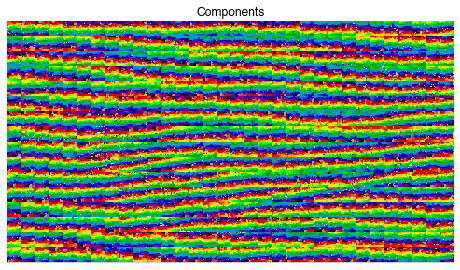

15


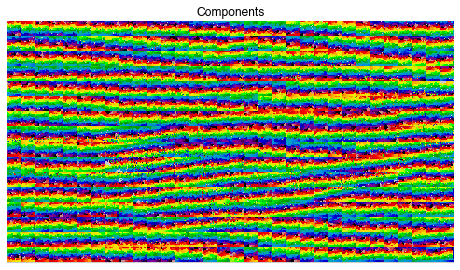

16


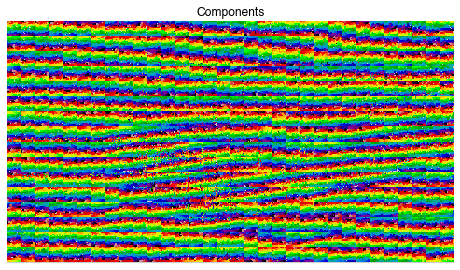

17


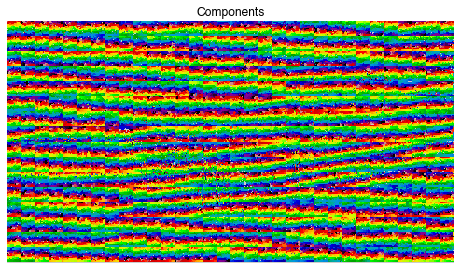

18


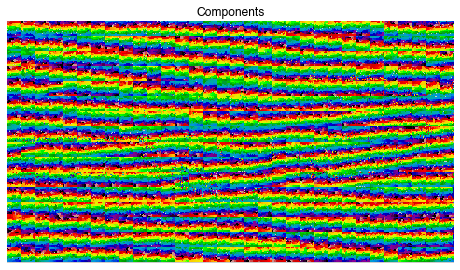

19


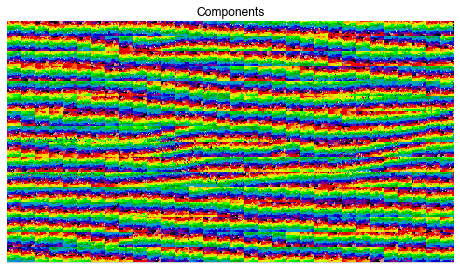

20


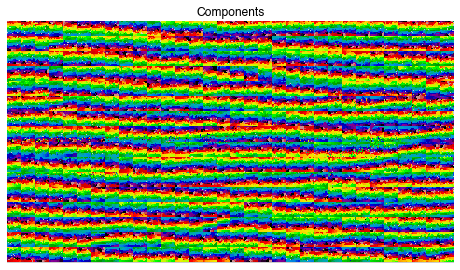

In [6]:
Y_d = zarr.open(f'{save_root}/Y_max.zarr', 'r')
mask = zarr.open(f'{save_root}/mask_map.zarr', 'r')
for n, n_ave_ in enumerate(Y_d):
    print(n)
    check_demix_cells_layer(save_root, n, nsplit = nsplit)

In [13]:
mask.shape

(21, 1108, 2048, 1)

In [ ]:
default_mask(dir_root, save_root, dask_tmp=None, memory_limit=0)

Scheduler: inproc://10.150.100.212/32981/1
Dashboard link: http://10.150.100.212/32981/1:42058/status
Compute default mask ---


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://10.150.100.212/32981/9 remote=inproc://10.150.100.212/32981/1>


In [18]:
from skimage.exposure import equalize_adapthist as clahe
from skimage.morphology import square, dilation
from skimage.segmentation import watershed,felzenszwalb
from sklearn.decomposition import NMF

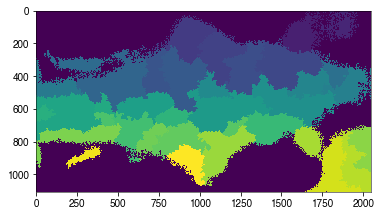

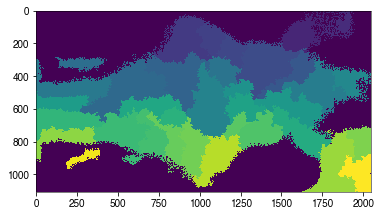

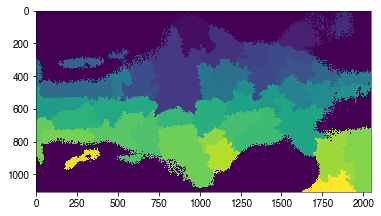

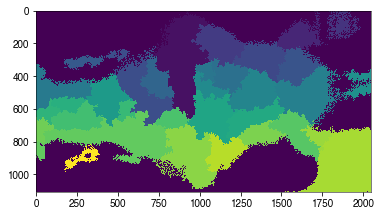

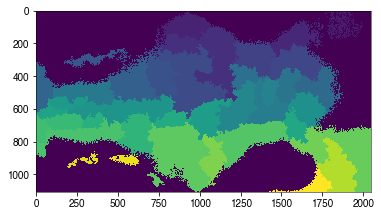

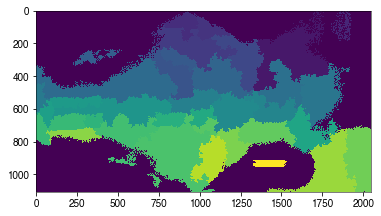

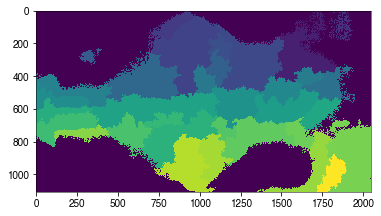

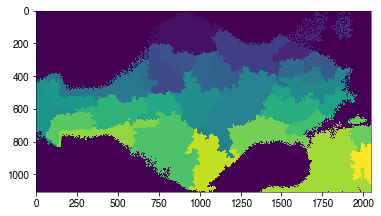

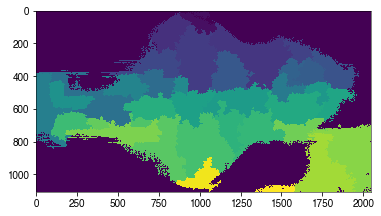

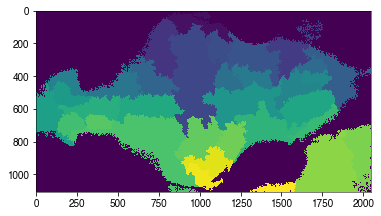

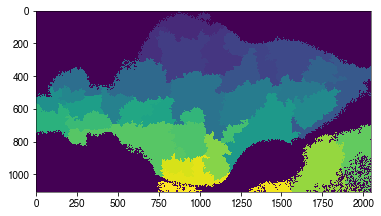

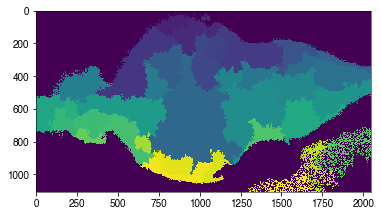

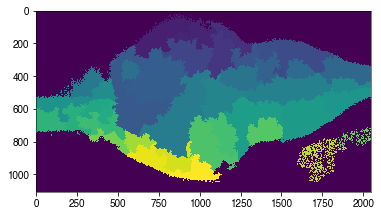

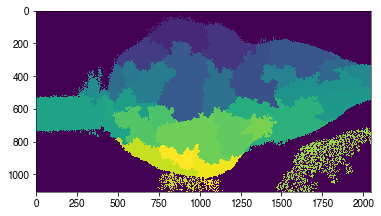

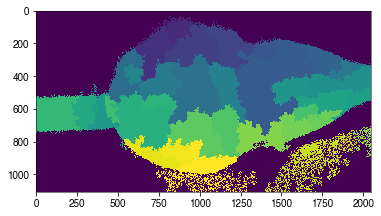

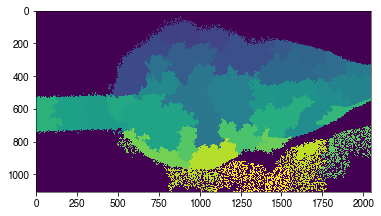

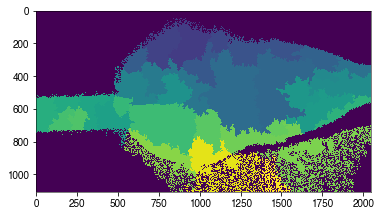

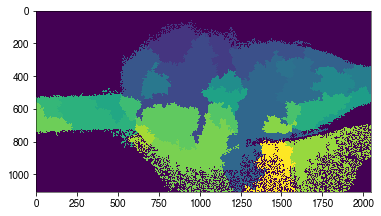

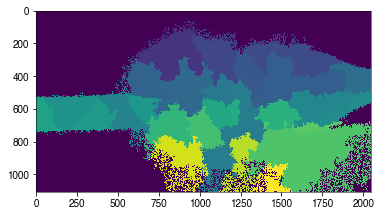

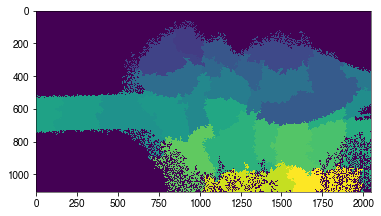

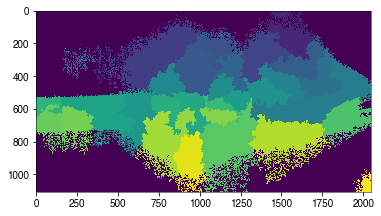

In [35]:
for n, n_ave_ in enumerate(Y_d):
    im_ = n_ave_.squeeze()
    min_, max_ = np.percentile(im_, [40, 95])
    im_ = np.clip(im_, min_, max_)
    im_[im_<=min_]=0
    # im_ = clahe(im_/im_.max(), clip_limit=0.03)
    segments_fz = felzenszwalb(im_, scale=100, sigma=0.5, min_size=5000)
    for n in range(segments_fz.min(), segments_fz.max()+1):
        if (im_[segments_fz==n]==0).mean()>0.5:
            segments_fz[segments_fz==n]=0
#     segments_slic = slic(img_adapteq, n_segments=250, compactness=10, sigma=1)
#     segments_watershed = watershed(img_adapteq, markers=100, compactness=0.01)
    plt.imshow(segments_fz)
    plt.show()

## df data after denoising

#### Take one block data for validation of denoise using local correlation

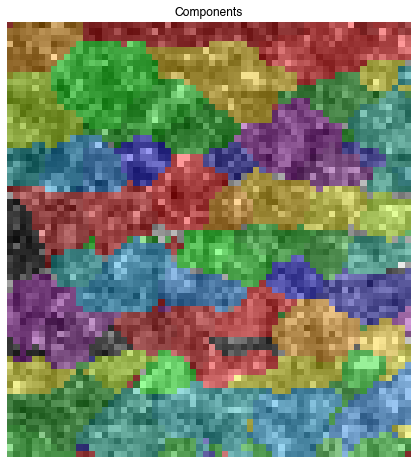

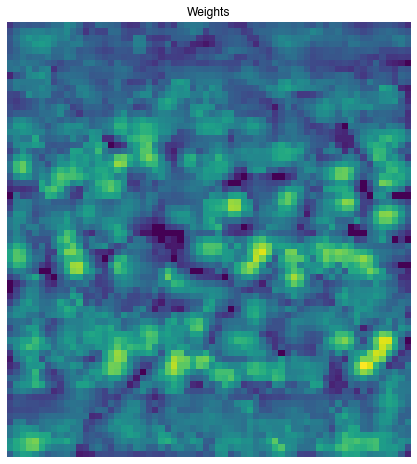

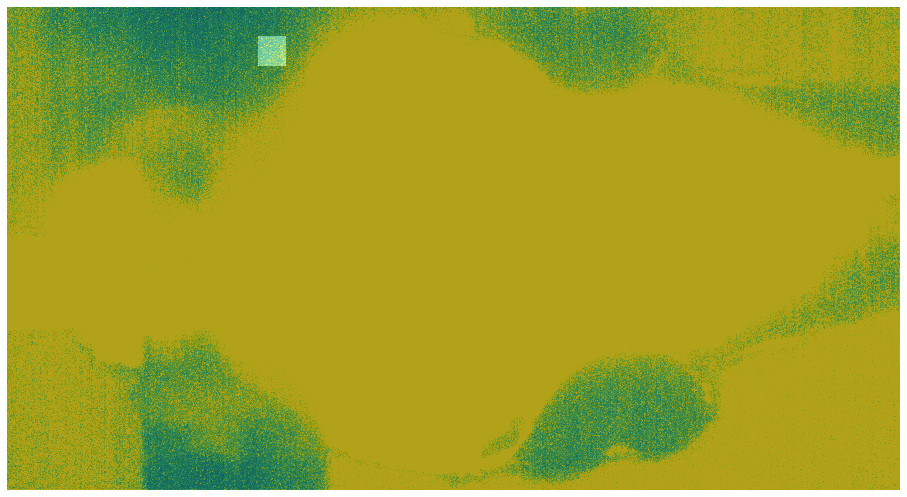

In [12]:
block_id = (10, 1, 9, 0)
check_demix_cells(save_root, block_id, plot_global=True, plot_mask=True)

In [27]:
from scipy.io import savemat
_ = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
_ = _.blocks[block_id]
savemat('tmp_dat_block.mat', {'neural_act':_})

In [26]:
_

dask.array<blocks, shape=(1, 138, 128, 10993), dtype=float32, chunksize=(1, 138, 128, 10993)>

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [10]:
# dff on raw data
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
baseline_t = da.map_blocks(baseline_from_Yd, trans_data_t, Y_d, dtype='float32')
_, nx, ny, _ = trans_data_t.chunksize
dff = Y_d/baseline_t

# dff on denoised data
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
dff_ = (Y_svd+Y_d.mean(axis=-1, keepdims=True))/baseline_t

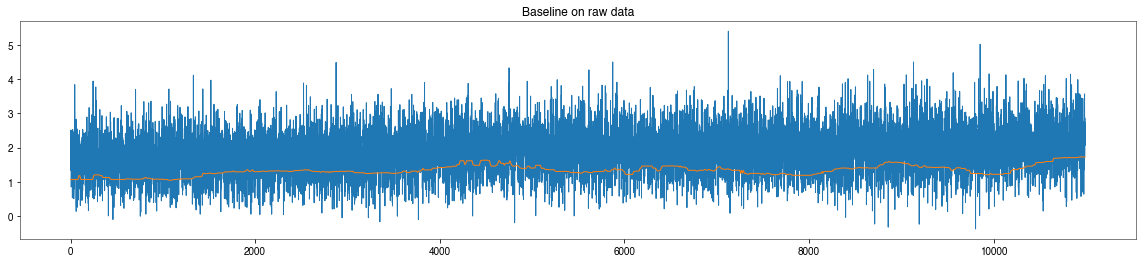

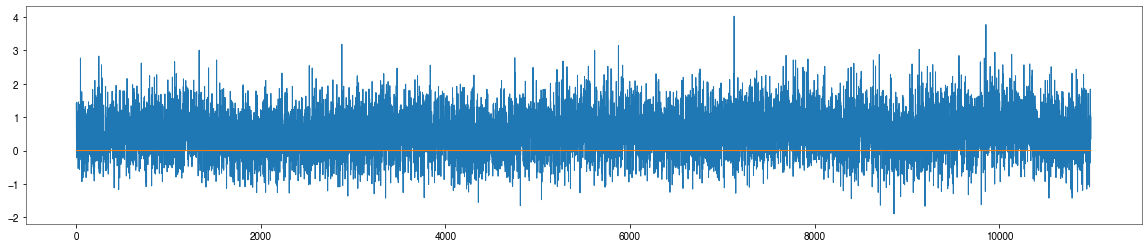

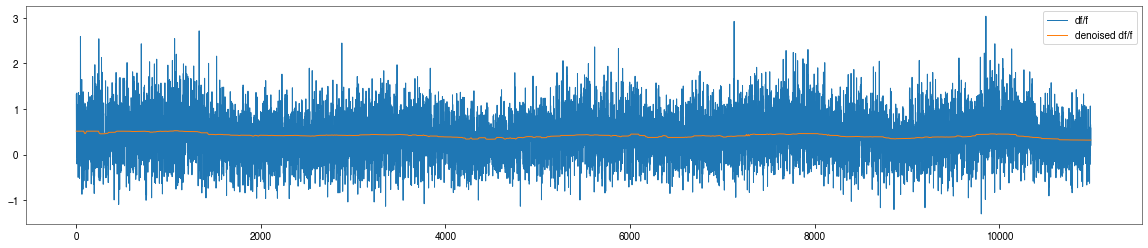

In [12]:
pix_id = (14, 500, 200)

plt.figure(figsize=(20, 4))
plt.plot(trans_data_t[pix_id])
plt.plot(baseline_t[pix_id])
# plt.ylim([0, 10])
plt.title('Baseline on raw data')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(Y_d[pix_id])
plt.plot(Y_svd[pix_id])
# plt.ylim([0, 10])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(dff[pix_id], label='df/f')
plt.plot(dff_[pix_id], label='denoised df/f')
plt.legend()
# plt.ylim([0, 10])
plt.show()

### df/f on raw cell data

In [ ]:
compute_cell_dff_raw(save_root, dask_tmp=dask_tmp, memory_limit=0)

Scheduler: inproc://10.150.100.226/28860/90
Dashboard link: http://10.150.100.226/28860/90:38868/status
